In [1]:
import contractions
import numpy as np
import re
import os
import pandas as pd
import numpy as np
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from scipy import stats
from bs4 import BeautifulSoup
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
#in order to use SMOTE, you've got to import Pipeline from imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# functions for plotting classification results
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print("="*80)
    print("Operating point = {:.3f}".format(t),end="\n\n")
    print("Confusion Matrix:")
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_ham', 'pred_spam'], 
                       index=['ham', 'spam']),end="\n\n")
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred_adj, target_names=['ham', 'spam']))
    
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold",fontdict=font)
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.01]);
    plt.xlim([0.0, 1.01]);
    plt.xlabel('Recall',fontdict=font);
    plt.ylabel('Precision',fontdict=font);
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold",fontdict=font)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score",fontdict=font)
    plt.xlabel("Decision Threshold",fontdict=font)
    plt.legend(loc='best',fontsize=16)
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
def plot_fpr_recall_vs_threshold(y_test, y_scores):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    
    
    fpr, tpr, roc_thresh = metrics.roc_curve(y_test, y_scores)
    p, r, prc_thresh = metrics.precision_recall_curve(y_test, y_scores)
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
   
    plt.figure(figsize=(8, 8))
    plt.title("False Positive and Recall Scores as a function of the decision threshold",fontdict=font)

    plt.plot(prc_thresh, r[:-1], "b--", label="Recall")
    plt.plot(roc_thresh, fpr, "g-", label="FPR")
    
    #plot vertical line where recall is highest (i.e. == 1)
    x_text = prc_thresh[0]
    plt.axvline(x=x_text)
    #plot horizontal line that will intersect where the vertical line hits the fpr line
    y_text = fpr[np.where(roc_thresh==find_nearest(roc_thresh, prc_thresh[0]))[0][0]]
    plt.axhline(y=y_text)
    x = round(x_text,2)
    y = round(y_text,2)
    plt.text(x_text,y_text,"({}, {})".format(x, y))
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best',fontsize=16)
    
def plot_prc(y_score, y_test):
    """
    Plot the precision-recall curve, labeled with average precision.
    """
    average_precision = metrics.average_precision_score(y_test, y_score)

    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    #plot it
    plt.figure(figsize=(8,8))
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision),fontsize=20)

In [3]:
def clean(doc):
    """
    Prepares text for NLP by stripping html tags; replacing urls with 'url'; and replacing email addresses
    with 'email'. It also expands contractions and lowercases everything. Finally, it only keeps words that 
    are at least three characters long, do not contain a number, and are no more than 17 chars long.
    
    Arguments:
        doc (str): A single document within the corpus.
        
    Returns:
        normalized (str): The normalized string.
    """
    
    
    def strip_html_tags(text):
        """
        Strips html tags from a string.
        """
        
        soup = BeautifulSoup(text, "html.parser")
        stripped_text = soup.get_text()
        return stripped_text

    def strip_urls(text):
        """
        Replaces urls in a string with 'url'.
        """
        
        url_re = re.compile(r"""(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))""")
        text = url_re.sub('url',text)
        return text

    def strip_emails(text):
        """
        Replaces email addresses in a string with 'email'.
        """
        email_re = re.compile(r'\S+@\S+')
        text = email_re.sub('email',text)
        return text

    def strip_nonsense(text):
        """
        Returns words from a string that are at least 3 characters long, do not contain a number, and 
        are no more than 17 chars long.
        """
        no_nonsense = re.findall(r'\b[a-z][a-z][a-z]+\b',text)
        text = ' '.join(w for w in no_nonsense if w != 'nan' and len(w) <= 17)
        return text

    def expand_contractions(text, contraction_mapping=contractions.contractions_dict):
        """
        Expands contractions within a string. For example, can't becomes cannot.
        """
        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                              flags=re.IGNORECASE|re.DOTALL)
        
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            if contraction_mapping.get(match):
                expanded_contraction = contraction_mapping.get(match)
            else:
                expanded_contraction = contraction_mapping.get(match.lower())
            if expanded_contraction:
                expanded_contraction = first_char+expanded_contraction[1:]
                return expanded_contraction
            else:
                pass

        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text

    doc = doc.lower()
    contraction_free = expand_contractions(doc)
    tag_free = strip_html_tags(contraction_free)
    url_free = strip_urls(tag_free)
    email_free = strip_emails(url_free)
    normalized = strip_nonsense(email_free)
    return normalized


def get_lemmas(document):
    """
    Lemmatizes the string of a single document after normalizing it with the clean function.
    
    Arguments:
        document (str): A single document within the corpus.
        
    Returns:
        lemmas_str (str): A space-delimited string of lemmas. This can be passed into a word vectorizer,
                          such as tf-idf.
    """
    def get_wordnet_pos(treebank_tag):
        """
        Converts the part of speech tag returned by nltk.pos_tag() to a value that can be passed 
        to the `pos` kwarg of wordnet_lemmatizer.lemmatize()
        """
        if treebank_tag.startswith('J'):
            return wn.ADJ
        elif treebank_tag.startswith('V'):
            return wn.VERB
        elif treebank_tag.startswith('N'):
            return wn.NOUN
        elif treebank_tag.startswith('R'):
            return wn.ADV
        else:
            return wn.NOUN
      
    stopword_set = set(stopwords.words('english'))
    text = word_tokenize(clean(document))
    word_pos = nltk.pos_tag(text)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word, pos in word_pos:
        pos = get_wordnet_pos(pos)
        lemma = wordnet_lemmatizer.lemmatize(word,pos=pos)
        if 'research' in lemma:
            lemmas.append('research')
        elif 'dataset' in lemma:
            lemmas.append('dataset')
        else:
            lemmas.append(lemma)
    lemmas_list = [lemma for lemma in lemmas if lemma not in stopword_set]
    lemmas_str = " ".join(lemma for lemma in lemmas)
    return lemmas_str

In [5]:
class log_uniform():        
    """
    Provides an instance of the log-uniform distribution with an .rvs() method. Meant to be used with 
    RandomizedSearchCV, particularly for params like alpha, C, gamma, etc. 
    
    Attributes:
        a (int or float): the exponent of the beginning of the range and 
        b (int or float): the exponent of the end of range. 
        base (int or float): the base of the logarithm. 10 by default.
    """
    
    def __init__(self, a=-1, b=0, base=10):
        self.loc = a
        self.scale = b - a
        self.base = base

    def rvs(self, size=1, random_state=None):
        uniform = stats.uniform(loc=self.loc, scale=self.scale)
        return np.power(self.base, uniform.rvs(size=size, random_state=random_state))

In [20]:
def randomized_grid_search(df, clf=SGDClassifier(), n_iter_search = 500, score='roc_auc'):
    """
    Given labeled training data (`df`) for a binary classification task, performs a 
    randomized grid search `n_iter_search` times using `clf` as the classifier the `score`
    as a scoring metric.
    
    Attributes:
        df (pandas DataFrame):  the training data. Currently, you must specify within the function
                                label and feature column names.
        clf (instance of an sklearn classifier):  SGDClassifier() by default
        n_iter_search:  number of parameter settings that are sampled. Trades off runtime vs quality 
                        of the solution.
        score (str):  the scorer used to evaluate the predictions on the test set. `roc_auc` by
                      default. Available options include:  accuracy, roc_auc, precision, fbeta, recall.
                      Note: for fbeta, beta is set to 1.5 to favor recall of the positive class.
    """
    scoring = {'accuracy': metrics.make_scorer(metrics.accuracy_score),
               'roc_auc': metrics.make_scorer(metrics.roc_auc_score),
               'precision': metrics.make_scorer(metrics.average_precision_score),
               'fbeta':metrics.make_scorer(metrics.fbeta_score,beta=1.5),
               'recall':metrics.make_scorer(metrics.recall_score)}
    clf_name = clf.__class__.__name__
    X = train_df['Normalized Comments']
    y = train_df['Spam']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        random_state=123)
    pipe = Pipeline([
                     ('vectorizer',TfidfVectorizer()),
                     ('upsample',SMOTE(ratio='minority')),
                     ('clf', clf)])

    param_dist = {
                  "vectorizer__ngram_range":[(1,1), (1,2), (1,3)],
                  "vectorizer__min_df":stats.randint(1,3),
                  "vectorizer__max_df":stats.uniform(.7,.3),
                  "vectorizer__sublinear_tf":[True, False],
                  "upsample__kind":['svm','regular'],
                  "clf__alpha": log_uniform(-5,2),
                  "clf__penalty": ['l2','l1','elasticnet'],
                  "clf__loss": ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                  }
    
    random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, 
                                       scoring=scoring, refit=score,
                                       n_iter=n_iter_search, cv=5,n_jobs=-1,verbose=1)
    random_search.fit(X_train, y_train)
    
    y_pred = random_search.predict(X_test)
    #get the col number of the positive class (i.e. spam)
    positive_class_col = list(random_search.classes_).index(1)
    try:
        y_score = random_search.predict_proba(X_test)[:,positive_class_col]
    except AttributeError:
        y_score = random_search.decision_function(X_test)
    average_precision = metrics.average_precision_score(y_test, y_score)
    acc = metrics.accuracy_score(y_test,y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred)
    precisions, recalls, _ = metrics.precision_recall_curve(y_test, y_score)
    auc = metrics.auc(recalls, precisions)
    fbeta = metrics.fbeta_score(y_test,y_pred,beta=1.5)
    recall = metrics.recall_score(y_test,y_pred)

    print("\tRecall on test data:  {0:.2f}".format(recall))
    print("\tAccuracy on test data:  {0:.2f}".format(acc))
    print("\tROC-AUC on test data:  {0:.2f}".format(roc_auc))
    print("\tFbeta on test data:  {0:.2f}".format(fbeta))
    print("\tAverage Precision on test data:  {0:.2f}".format(average_precision))
    print("\tPrecision-Recall AUC on test data:  {0:.2f}".format(auc))
    print("-"*80)
    print("Classification Report:")
    class_names = ['ham', 'spam']
    print(metrics.classification_report(y_test, y_pred, target_names=class_names))
    print("-"*80)
    plot_prc(y_score, y_test)
    print("-"*80)
    fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_score)
    print("AUC of ROC:  {0:.4f}".format(metrics.auc(fpr, tpr)))
    plot_roc_curve(fpr, tpr, 'ROC Curve')
    best_estimator = random_search.best_estimator_
    best_score = random_search.best_score_
    result_values = [y_pred, y_score, precisions, recall, average_precision,
                     acc, roc_auc, auc, fbeta, recalls, best_score, best_estimator, y_test]
    result_keys = ['y_pred', 'y_score', 'precisions', 'recall', 'average_precision','acc',
                   'roc_auc', 'auc', 'fbeta', 'recalls','best_score','best_estimator','y_test']
    results = {k:v for k,v in zip(result_keys,result_values)}
    
    return results

# Import the Data

In [8]:
ordinal_questions = ["Experience Rating",
                     "Likely to Return",
                     "Likely to Recommend",
                     "Able to Accomplish"
                     ]

train_path = os.path.join(os.getcwd(),'training-sw.xlsx')
train_df = pd.read_excel(train_path)

In [10]:
train_df['Normalized Comments'] = train_df['Comments Concatenated'].astype(str).apply(get_lemmas)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


# Randomized Grid Search

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 26.0min finished


	Recall on test data:  0.76
	Accuracy on test data:  0.86
	ROC-AUC on test data:  0.82
	Fbeta on test data:  0.68
	Average Precision on test data:  0.68
	Precision-Recall AUC on test data:  0.70
--------------------------------------------------------------------------------
Classification Report:
             precision    recall  f1-score   support

        ham       0.95      0.88      0.91      2227
       spam       0.55      0.76      0.64       429

avg / total       0.89      0.86      0.87      2656

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
AUC of ROC:  0.9074


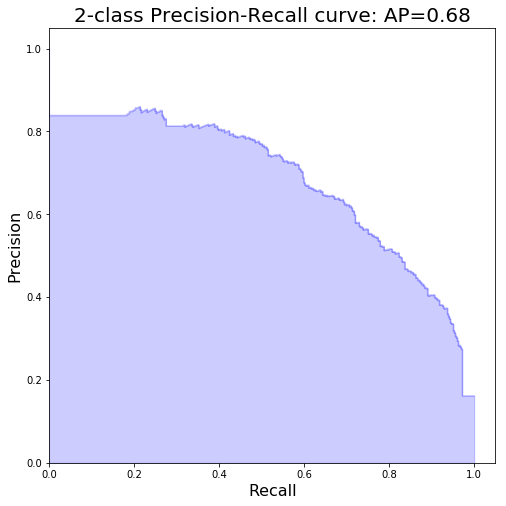

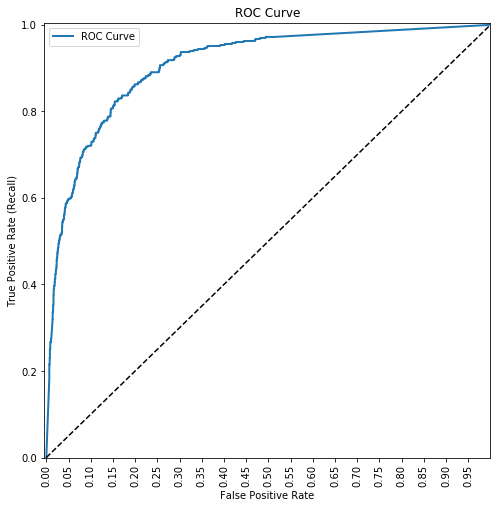

In [21]:
results = randomized_grid_search(train_df, clf = SGDClassifier(), n_iter_search=100, score='roc_auc')

# Model Analysis

### Classification Report
For the printed classification report:
>**Precision** - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. 
 - Tells us the proportion of predicted suspicious that was actually suspicious.
$$Precision = TP/TP+FP$$

>**Recall (Sensitivity)** - Recall is the ratio of correctly predicted positive observations to the all observations in actual class. 
 - Tells us of all the samples that were suspicious, how many did we predict as suspicious?
$$Recall = TP/TP+FN$$

>**F1 score** - The F1 score is the weighted average of precision and recall. It's similar to accuracy, but is usually more useful than accuracy when you have an uneven class distribution.
$$F1 Score = 2*(Recall * Precision) / (Recall + Precision)$$

### Benchmark against dummy classifiers
These dummy classifiers will make different sorts of educated guesses on whether or not a comment is spam or ham. Hopefully our trained classifer out-performs these guesses.

In [22]:
X = np.zeros(shape=train_df.shape)
y = train_df['Spam']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=123)
for strategy in ['stratified','most_frequent','prior','uniform']:
    print("="*80)
    print(strategy)
    print("="*80)
    dummy = DummyClassifier(strategy=strategy)
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    #get the col number of the positive class (i.e. spam)
    positive_class_col = list(dummy.classes_).index(1)
    y_score = dummy.predict_proba(X_test)[:,positive_class_col]
    average_precision = metrics.average_precision_score(y_test, y_score)
    acc = metrics.accuracy_score(y_test,y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred)
    precisions, recalls, _ = metrics.precision_recall_curve(y_test, y_score)
    auc = metrics.auc(recalls, precisions)
    fbeta = metrics.fbeta_score(y_test,y_pred,beta=2)
    recall = metrics.recall_score(y_test,y_pred)
    print("\tRecall on test data:  {0:.2f}".format(recall))
    print("\tAccuracy on test data:  {0:.2f}".format(acc))
    print("\tROC-AUC on test data:  {0:.2f}".format(roc_auc))
    print("\tFbeta on test data:  {0:.2f}".format(fbeta))
    print("\tAverage Precision on test data:  {0:.2f}".format(average_precision))
    print("\tPrecision-Recall AUC on test data:  {0:.2f}".format(auc))

stratified
	Recall on test data:  0.22
	Accuracy on test data:  0.77
	ROC-AUC on test data:  0.54
	Fbeta on test data:  0.22
	Average Precision on test data:  0.14
	Precision-Recall AUC on test data:  0.21
most_frequent
	Recall on test data:  0.00
	Accuracy on test data:  0.86
	ROC-AUC on test data:  0.50
	Fbeta on test data:  0.00
	Average Precision on test data:  0.14
	Precision-Recall AUC on test data:  0.57
prior
	Recall on test data:  0.00
	Accuracy on test data:  0.86
	ROC-AUC on test data:  0.50
	Fbeta on test data:  0.00
	Average Precision on test data:  0.14
	Precision-Recall AUC on test data:  0.57
uniform
	Recall on test data:  0.47
	Accuracy on test data:  0.49
	ROC-AUC on test data:  0.48
	Fbeta on test data:  0.31
	Average Precision on test data:  0.14
	Precision-Recall AUC on test data:  0.57


## Maximizing recall by adjusting the decision threshold 
The `precision_recall_curve` and `roc_curve` are useful tools to visualize the recall-specificty tradeoff in the classifier. We can use them to set the decision threshold of the model to maximize either recall or specificity. This is called the **operating point** of the model. We'll maximize recall (at the expense of our false positive rate).

>We can fine tune the model's operating point with the methods `predict_proba()` and `decision_function()`. These return the raw probability that a sample is predicted to be in a class.

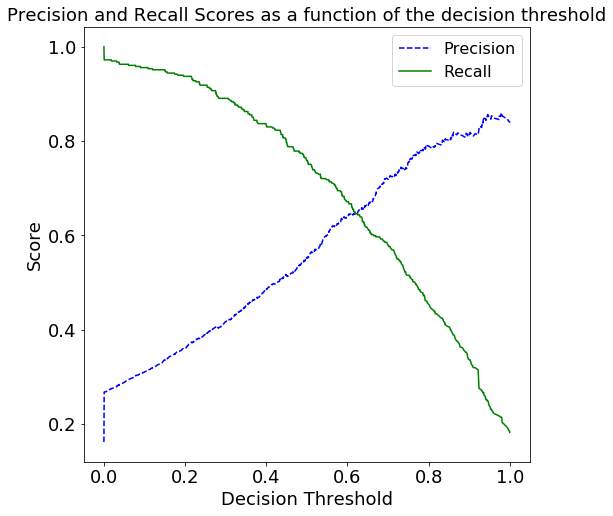

In [26]:
# plot precision and recall as a function of the decision threshold
y_scores = results['y_score']
y_test = results['y_test']
p, r, thresholds = metrics.precision_recall_curve(y_test, y_scores)
plot_precision_recall_vs_threshold(p, r, thresholds)

Operating point = 0.500

Confusion Matrix:
      pred_ham  pred_spam
ham       1963        264
spam       104        325

Classification Report:
             precision    recall  f1-score   support

        ham       0.95      0.88      0.91      2227
       spam       0.55      0.76      0.64       429

avg / total       0.89      0.86      0.87      2656

Operating point = 0.489

Confusion Matrix:
      pred_ham  pred_spam
ham       1949        278
spam        98        331

Classification Report:
             precision    recall  f1-score   support

        ham       0.95      0.88      0.91      2227
       spam       0.54      0.77      0.64       429

avg / total       0.89      0.86      0.87      2656

Operating point = 0.478

Confusion Matrix:
      pred_ham  pred_spam
ham       1934        293
spam        95        334

Classification Report:
             precision    recall  f1-score   support

        ham       0.95      0.87      0.91      2227
       spam       0.53      

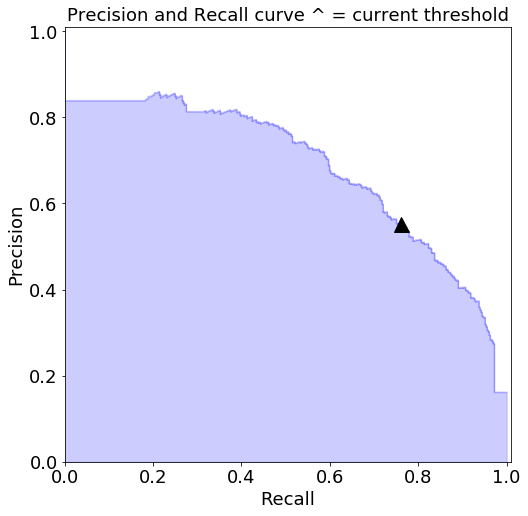

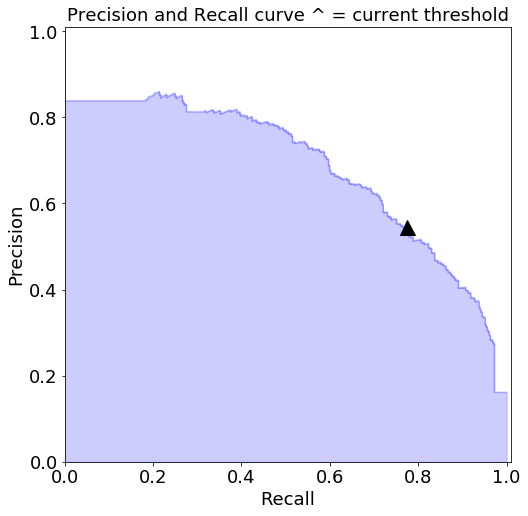

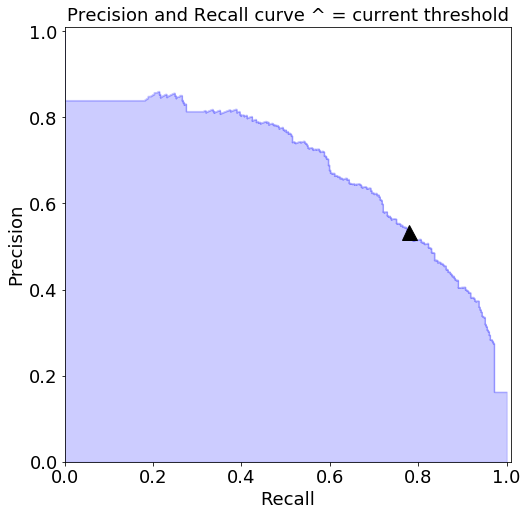

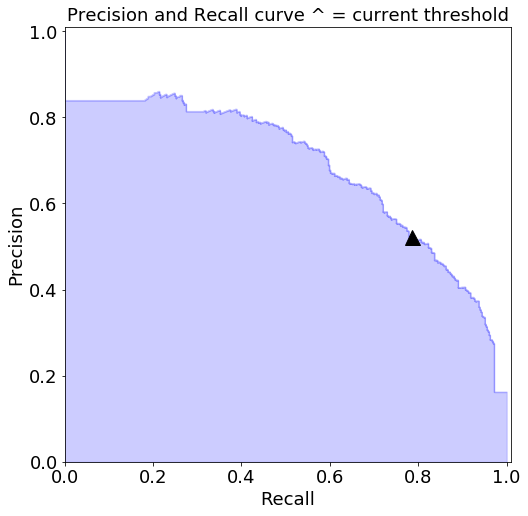

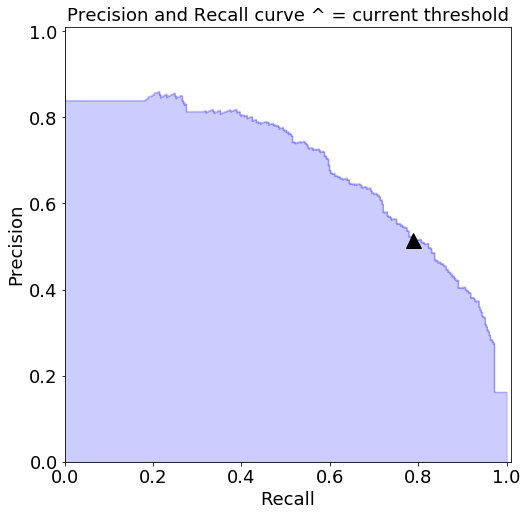

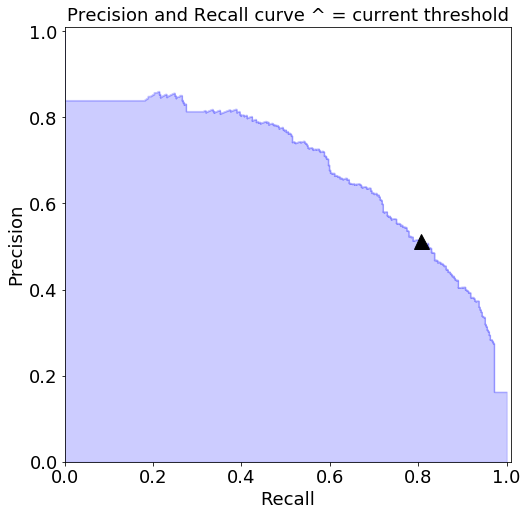

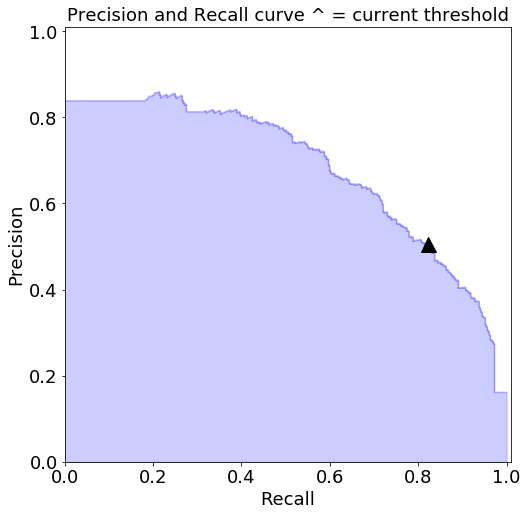

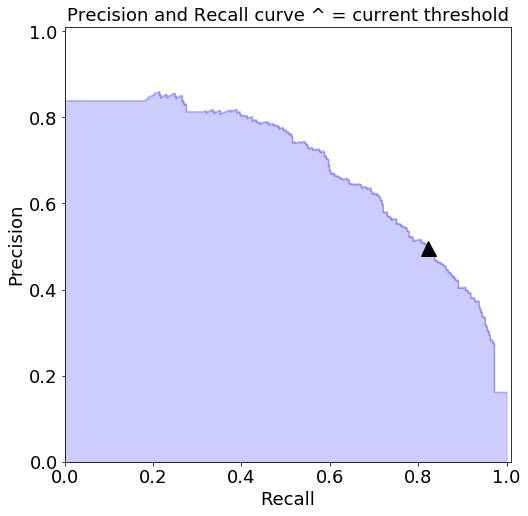

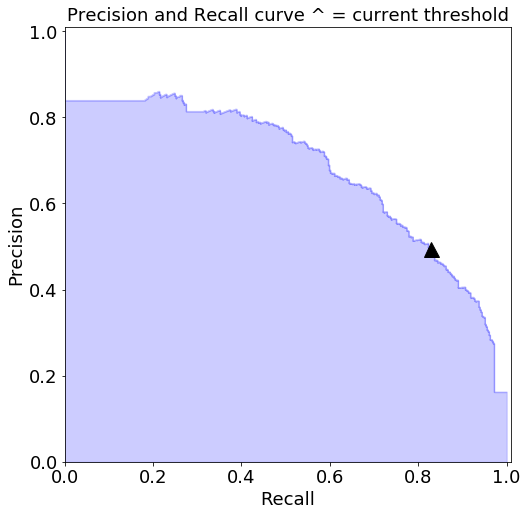

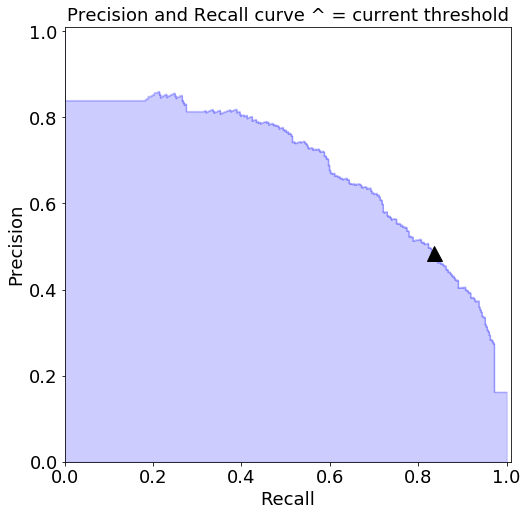

In [28]:
# generate confusion matrices and classifation reports with respect to different operating points
# also plot the precision-recall curve with the new threshold labeled

op_points = np.linspace(.5,.4,num=10)
for i in op_points:
    precision_recall_threshold(p, r, thresholds, i)

### False Positives as a function of the decision threshold

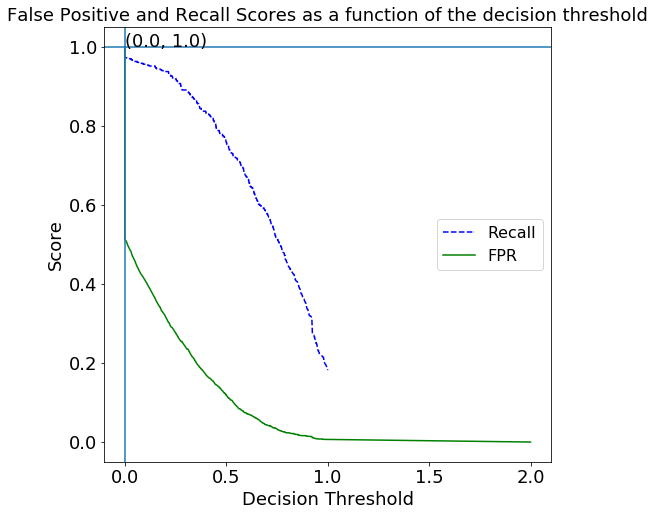

In [31]:
plot_fpr_recall_vs_threshold(y_test, y_scores)